In [1]:
import numpy as np
import pandas as pd

from time_matrix.structuring_and_exploration import panelDataSet

import matplotlib.pyplot as plt

from time_matrix.matrix_completion import validation, LAPIS, softImpute, r1Comp

from numpy.linalg import matrix_rank

from scipy.stats import bernoulli

import time_matrix.estimation_and_inference as ef


In [2]:

### Loading Smoking Data
longSmokingData = pd.read_csv('./Smoking in California/smoking_data.csv', index_col=0)

### Adding indicator variable to define treatment period for appropriate units
longSmokingData['law_passed'] = np.array((longSmokingData['state'] == 'California') & 
                                         (longSmokingData['year'] >= 1989), dtype='int32')

In [3]:
### A panel data object for the response variable (sigsale)
smokingPanelData = panelDataSet(longSmokingData, 'state', 'year', 'cigsale')

In [4]:
### Parsing out the units in the panel data set, to explore the individual time series in more detail
parsedData =smokingPanelData.parseUnits()

In [5]:
### Getting the wide format for the cigsale panel data 
responseDataWide = smokingPanelData.getWideFormat()

In [6]:
### A panel data object for the law indicator (law_passed)
lawPanelData = panelDataSet(longSmokingData, 'state', 'year', 'law_passed')

### The wide format for this data corresponds to the needed missingness matrix
D = lawPanelData.getWideFormat()

# Estimating Effect of Prop99 on Smoking Rates

In [7]:
### Using a softImpute model to estimate the unobserved untreated potential outcomes

### Finding best penalty parameter
validationSoftImpute = validation(responseDataWide.values, D.values, 
                                  softImpute, np.linspace(0, 100, 10))

bestLambda = validationSoftImpute.idxmin()

### Building best model
softMod = softImpute(bestLambda)

softImputeMatrix = softMod.fit(responseDataWide.values, D.values)

softImputeMatrix = pd.DataFrame(softImputeMatrix, 
                                index = responseDataWide.index, columns = responseDataWide.columns)

In [8]:
### Getting treatment effect estimate data for this data set 
### In this case, only one state was "treated"
prop99EffectData = ef.makeTreatmentDataFrame(responseDataWide, softImputeMatrix, D)

Text(0.5, 1.0, 'Cigarette Sales in California')

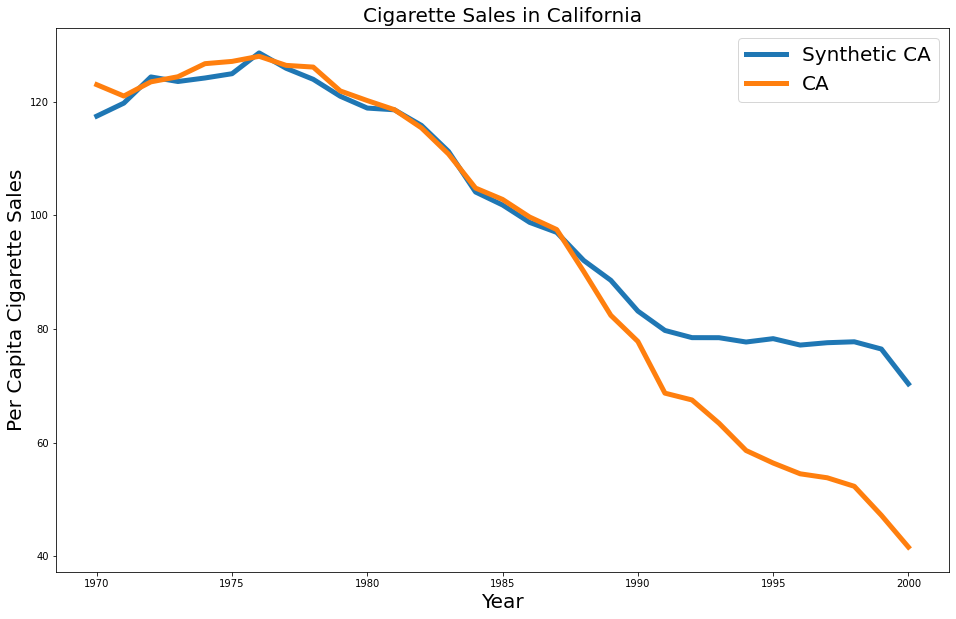

In [9]:
### Comparing the observed California data to the estimated untreated potential outcome series for California
plt.figure(figsize=(16, 10))

line1, = plt.plot(pd.Series(softImputeMatrix.columns).values, softImputeMatrix.loc['California', :], linewidth=5)

line2, = plt.plot(pd.Series(softImputeMatrix.columns).values, responseDataWide.loc['California', :], linewidth=5)

plt.xlabel('Year', fontsize=20)
plt.ylabel('Per Capita Cigarette Sales', fontsize=20)

plt.legend([line1, line2], ['Synthetic CA', 'CA'], prop={'size': 20})
plt.title("Cigarette Sales in California", fontsize=20)

# Bootstrapped Confidence Interval Generation 

In [10]:
### Generating stratified bootstrapped data sets from which confidence intervals will be generated
bootstrappedYs, bootstrappedFullDs , bootstrappedTreatedDs = ef.bootstrappedDataGenerator(responseDataWide, 
                                                                                       D, D, 300)

In [11]:
dataFrameList = []

for b in bootstrappedYs.keys():
    ### For each bootstrapped data set, we estimate the treament effect
    YThisIteration = bootstrappedYs[b]

    missingnessDThisIteration = bootstrappedFullDs[b]
    
    treatedDThisIteration = bootstrappedTreatedDs[b]
    
    ### For every data set, we build a suitable matrix completion model
    validationSoftImpute = validation(YThisIteration.values, missingnessDThisIteration.values, 
                                         softImpute, np.linspace(0, 100, 10))

    bestLambda = validationSoftImpute.idxmin()

    softMod = softImpute(bestLambda)

    softImputeMatrix = softMod.fit(YThisIteration.values, missingnessDThisIteration.values)

    softImputeMatrix = pd.DataFrame(softImputeMatrix, index = YThisIteration.index, columns = YThisIteration.columns)
    
    ### Given the observed data matrix, and the estimated untreated potential outcome matrix
    ### we estimate the treatment effect for all units that received the treatment,
    ### when they were receiving the treatment. 
    effectDataThisIteration = ef.makeTreatmentDataFrame(YThisIteration, softImputeMatrix, treatedDThisIteration)
    
    effectDataThisIteration['bootstrap_iteration'] = b
    
    dataFrameList.append(effectDataThisIteration)

### Concatenate the treatment data sets from each bootstrap iteration together to get the final bootstrapped 
### treatment effect data set
concattedTreatmentData = pd.concat(dataFrameList).reset_index()

In [12]:
### Calculating a 95% confidence interval for the treatment effect,
### using the percentile method. 
groupedSet = concattedTreatmentData.groupby('year')['estimated_effect']

lowerData = groupedSet.apply(lambda x:np.quantile(x, .025))

lowerData.name = 'lower'

upperData = groupedSet.apply(lambda x:np.quantile(x, .975))

upperData.name = 'upper'

confIntDataFrame = pd.concat((lowerData, upperData), axis=1).reset_index()



In [13]:
### Merging confidence interval data with treatment effect data 
prop99EffectData = prop99EffectData.merge(confIntDataFrame)
prop99EffectData['year'] = pd.to_numeric(prop99EffectData['year'])

Text(0.5, 1.0, "Proposition 99's Effect on Cigarette Sales, 95% Confidence Interval Provided")

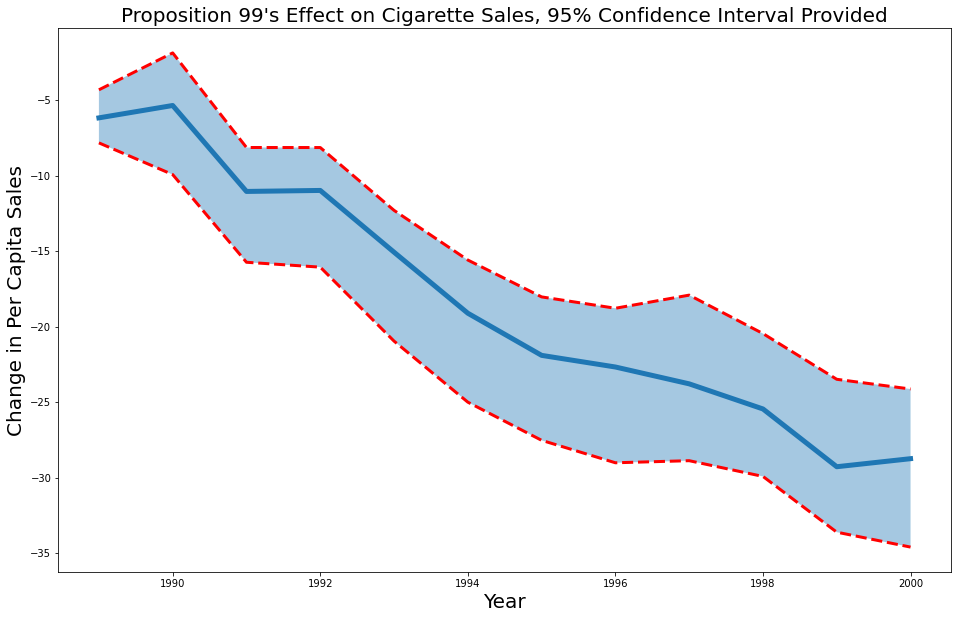

In [14]:
### Plotting the treatment effect estimate, along with a 95% bootstrapped confidence interval.
plt.figure(figsize=(16, 10))

plt.plot(prop99EffectData['year'], prop99EffectData['estimated_effect'], linewidth=5)

plt.plot(prop99EffectData['year'],  prop99EffectData['lower'], '--', linewidth=3, c='r')

plt.plot(prop99EffectData['year'], prop99EffectData['upper'], '--', linewidth=3, c='r')

plt.fill_between(prop99EffectData['year'], prop99EffectData['lower'], prop99EffectData['upper'], alpha=0.4)

plt.xlabel('Year', fontsize=20)

plt.ylabel('Change in Per Capita Sales', fontsize=20)

plt.title("Proposition 99\'s Effect on Cigarette Sales, 95% Confidence Interval Provided", fontsize=20)